<a href="https://colab.research.google.com/github/warenya/OP-GSP-Image-Stitching/blob/main/cliffordTIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python-headless numpy scipy matplotlib
!pip install clifford
!pip install numba==0.58.1
import cv2
import numpy as np
from scipy.optimize import minimize
import scipy.spatial
import scipy.interpolate
import matplotlib.pyplot as plt
import math
from clifford import Cl
import torch
import torch.nn as nn
import torch.optim as optim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.44.0
    Uninstalling llvmlite-0.44.0:
      Successfully uninstalled llvmlite-0.44.0
  Attempting uninstall: numba
    Found existing installation: numba 0.61.0
    Uninstalling numba-0.61.0:
      Successfully uninstalled numba-0.61.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba-cuda 0.0.17.1 requires numba>=0.59.1, but you have numba 0.58.1 which is incompatible.


In [3]:
def find_red_spot(image):
    """Identifies the red spot in the image and returns its coordinates."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define red color range in HSV
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    # Create a mask for red colors
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(largest_contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            return (cx, cy)
    return None

In [4]:
def overlay_grid(image, grid_size=10):
    """Overlays a grid on the image and returns the cell containing the red spot."""
    height, width, _ = image.shape
    cell_width = width // grid_size
    cell_height = height // grid_size

    # Draw the grid
    for i in range(1, grid_size):
        cv2.line(image, (i * cell_width, 0), (i * cell_width, height), (255, 255, 255), 1)
        cv2.line(image, (0, i * cell_height), (width, i * cell_height), (255, 255, 255), 1)

    # Find red spot position
    red_spot = find_red_spot(image)
    if red_spot:
        cx, cy = red_spot
        grid_x = cx // cell_width
        grid_y = cy // cell_height
        cv2.circle(image, (cx, cy), 5, (0, 255, 0), -1)  # Mark red spot

        return (grid_x, grid_y), (cx, cy), image

In [5]:
from clifford.g3 import *

def generate_clifford_vector(image, red_spot):
    """Uses Clifford algebra to generate a horizontal vector from the red spot."""
    if red_spot is None:
        return None, None, image

    height, width, _ = image.shape
    cx, cy = red_spot

    G2, blades = Cl(2)
    e1 = blades['e1']
    e2 = blades['e2']

    # Define red spot as a Clifford vector
    red_point = cx * e1 + cy * e2

    # Generate horizontal and vertical components from the red spot
    vector = (width - cx) * e1  + (height - cy) * e2

    # Draw vector on image
    end_x = width - 1
    end_y = height - 1
    cv2.arrowedLine(image, (cx, cy), (end_x, end_y), (0, 255, 0), 2)

    return red_point, vector, image

In [6]:
def translate_vector(red_point1, red_point2, vector2):
    """
    Translates vector2 using a Clifford algebra translation motor so that red_point2 aligns with red_point1.
    """
    # Compute translation difference
    translation = red_point1 - red_point2

    # Apply translation to vector2
    translated_vector = vector2 + translation

    return translated_vector

In [16]:
def apply_translation_rotation(image2, red_spot2, vector2, red_spot1, vector1):
    """Applies translation and rotation to align the second image with the first."""
    # Compute translation: how much image2 needs to be moved
    translation_x = red_spot1[0] - red_spot2[0]
    translation_y = red_spot1[1] - red_spot2[1]

    # Compute rotation angle to align the vectors
    angle = np.arctan2(vector1[1], vector1[0]) - np.arctan2(vector2[1], vector2[0])

    # Rotation matrix based on the angle
    rotation_matrix = cv2.getRotationMatrix2D((red_spot2[0], red_spot2[1]), np.degrees(angle), 1)

    # Translate the second image
    translated_image = cv2.warpAffine(image2, np.float32([[1, 0, translation_x], [0, 1, translation_y]]), (image2.shape[1], image2.shape[0]))

    # Apply rotation to the translated image
    rotated_image = cv2.warpAffine(translated_image, rotation_matrix, (image2.shape[1], image2.shape[0]))

    return rotated_image

In [8]:
def plot_overlapping_vectors(image1, image2, red_spot1, red_spot2, vector1, aligned_vector2, overlap_ratio, output_width, output_height):
    """Plots the two images and vectors to check alignment after translation and shows overlap ratio."""

    # Convert images to RGB for matplotlib
    img1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Overlay images (blend them for better visualization)
    combined = cv2.addWeighted(img1_rgb, 0.5, img2_rgb, 0.3, 0)

    plt.figure(figsize=(10, 5))
    plt.imshow(combined)

    # Extract red spot positions
    cx1, cy1 = red_spot1
    cx2, cy2 = red_spot2

    # Compute end points for vectors
    end_x1 = cx1 + vector1[0]  # Vector 1 end x-coordinate
    end_x2 = cx2 + aligned_vector2[0]  # Translated vector 2 end x-coordinate

    # Plot red spots
    plt.scatter(cx1, cy1, color='red', marker='o', s=100, label="Red Spot 1")
    plt.scatter(cx2, cy2, color='blue', marker='o', s=100, label="Red Spot 2 (Before Alignment)")

    # Draw original and aligned vectors
    plt.arrow(cx1, cy1, end_x1 - cx1, 0, color='lime', width=5, label="Vector 1")
    plt.arrow(cx2, cy2, end_x2 - cx2, 0, color='cyan', width=5, label="Aligned Vector 2")

    # Add overlap ratio and output dimensions to the plot
    plt.text(0.05, 0.95, f'Overlap Ratio: {overlap_ratio:.3f}', color='white', fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
    plt.text(0.05, 0.90, f'Output Width: {output_width}', color='white', fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
    plt.text(0.05, 0.85, f'Output Height: {output_height}', color='white', fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)

    plt.legend()
    plt.title("Overlapping Vectors After Clifford Translation")
    plt.axis("off")
    plt.show()

    return red_spot1, red_spot2, vector1, aligned_vector2

In [9]:
def stitch_images(image1, image2, red_spot1, red_spot2, vector1, vector2):
    """
    Stitches two images together using translation and rotation.
    """
    # Apply translation and rotation to align the second image with the first
    aligned_image2 = apply_translation_rotation(image2, red_spot2, vector2, red_spot1, vector1)

    # Now blend the images by overlaying them
    stitched_image = np.copy(image1)
    mask = aligned_image2 > 0  # Mask for the non-black pixels in image2

    # Overlay the second image onto the first one where the second image is non-zero
    stitched_image[mask] = aligned_image2[mask]

    return stitched_image

Red Point 1: (194^e1) + (137^e2)
Vector 1: (446^e1) + (375^e2)
Red Point 2: (162^e1) + (150^e2)
Vector 2: (478^e1) + (362^e2)
Vectors can be used for stitching.


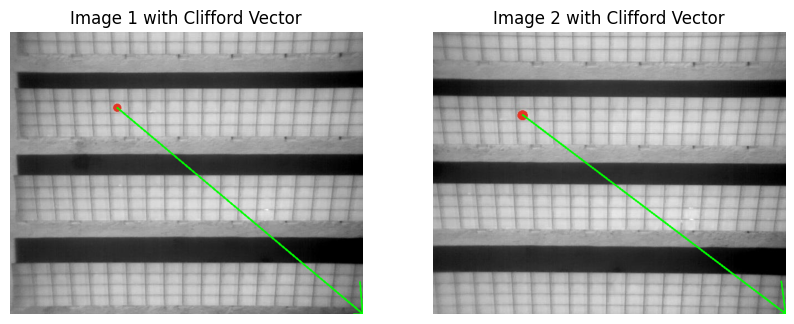

Original Vector 2: (478^e1) + (362^e2)
Aligned Vector 2: (510^e1) + (349^e2)


<ipython-input-16-2f28ab1c403d>:8: DeprecationWarning: Treating MultiVector objects like a sequence is deprecated. To access the coefficients as a sequence, use the `.value` attribute.
  angle = np.arctan2(vector1[1], vector1[0]) - np.arctan2(vector2[1], vector2[0])


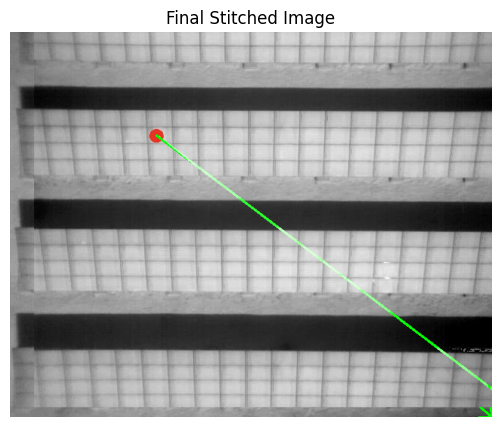

In [17]:
def main():
  # Load images (Replace with your image paths)
  image1 = cv2.imread("/T00024IR.JPG")
  image2 = cv2.imread("/T00025IR.JPG")


  if image1 is None or image2 is None:
      print("Error loading images!")
  else:
      # Detect red spot
      red_spot1 = find_red_spot(image1)
      red_spot2 = find_red_spot(image2)

      # Generate Clifford vectors
      red_point1, vector1, processed_image1 = generate_clifford_vector(image1, red_spot1)
      red_point2, vector2, processed_image2 = generate_clifford_vector(image2, red_spot2)

      if vector1 is not None and vector2 is not None:
          print(f"Red Point 1: {red_point1}")
          print(f"Vector 1: {vector1}")
          print(f"Red Point 2: {red_point2}")
          print(f"Vector 2: {vector2}")
          print("Vectors can be used for stitching.")
      else:
          print("Could not find red spots in both images.")

      plt.show()

    # Convert images to RGB for displaying in Colab
  processed_image1 = cv2.cvtColor(processed_image1, cv2.COLOR_BGR2RGB)
  processed_image2 = cv2.cvtColor(processed_image2, cv2.COLOR_BGR2RGB)
  # Show images
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(processed_image1)
  axes[0].set_title("Image 1 with Clifford Vector")
  axes[0].axis("off")

  axes[1].imshow(processed_image2)
  axes[1].set_title("Image 2 with Clifford Vector")
  axes[1].axis("off")

  plt.show()

  if vector1 is not None and vector2 is not None:
    aligned_vector2 = translate_vector(red_point1, red_point2, vector2)
    print(f"Original Vector 2: {vector2}")
    print(f"Aligned Vector 2: {aligned_vector2}")

  stitched_image = stitch_images(image1, image2, red_spot1, red_spot2, vector1, vector2)
  # Show the final stitched image
  plt.figure(figsize=(10, 5))
  plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
  plt.title("Final Stitched Image")
  plt.axis("off")
  plt.show()

if __name__ == "__main__":
    main()